# Load me

In [1]:
# LOAD ME
import logging
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from py_ballisticcalc import Shot, DragModel, Ammo, Velocity, Weight, Distance, TableG7, TableGS
from py_ballisticcalc import Calculator, loadMetricUnits, logger
from py_ballisticcalc import PreferredUnits, TrajFlag, Angular
logger.setLevel(logging.WARNING)
loadMetricUnits()
PreferredUnits.drop = Distance.Meter
calc = Calculator(engine="scipy_engine")

# Coordinates

**Gravity gives $y$:** In ballistics, everything is referenced to the direction of gravity. The gravity vector points "down." In 3D Cartesian coordinates $(x, y, z)$, the gravity vector is $(0, -g, 0)$, where $g$ is the acceleration due to gravity (typically 32 feet/second² or 9.8 meters/second²). The $y$ coordinate describes vertical (up/down) position.

**Sight gives $x$:** The second key reference in ballistics is the **sight line**. We set the origin of our coordinate system $(0, 0, 0)$ at the sight, which is usually either the shooter’s eye or the center of a sighting device like a scope. The sight line is the vector starting at the origin and pointing in the exact direction of the sight.

We use the $x$ coordinate to measure horizontal distance from the sight. What is **horizontal**? Any vector orthogonal to the gravity vector. So, point the sight in any horizontal direction and that's the $x$ axis.

The $z$ coordinate describes position orthogonal to both the direction of gravity and the sight line. From the perspective of the sight, this is lateral position, also known as windage.

## Diagram

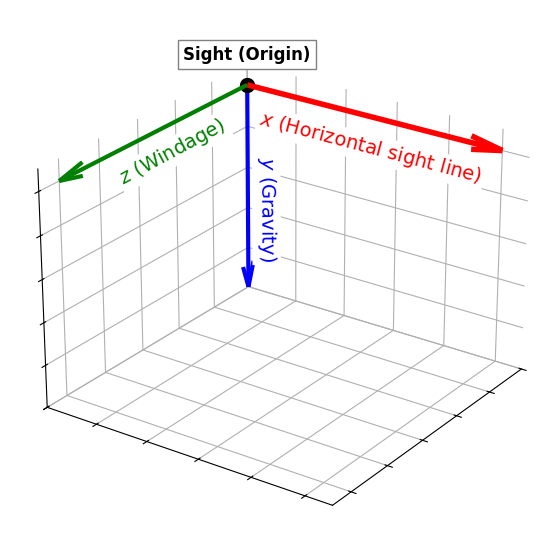

In [2]:
# Create illustration of ballistic coordinate system
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=25, azim=35)
arrow_length = 1.0
# "x" is plot-y, "y" is plot-z, "z" is plot-x
ax.quiver(0, 0, 1, 0, arrow_length, 0, color='red', linewidth=4, arrow_length_ratio=0.12)
ax.text(0, 0.5, 0.85, '$x$ (Horizontal sight line)', color='red', fontsize=14, zdir='y', va='center', ha='center',
        bbox=dict(facecolor='white', edgecolor='none', pad=2))
ax.quiver(0, 0, 1, 0, 0, -arrow_length, color='blue', linewidth=3, arrow_length_ratio=0.12)
ax.text(0.1, 0.1, 0.47, '$y$ (Gravity)', color='blue', fontsize=14, zdir='z', va='center', ha='left',
        bbox=dict(facecolor='white', edgecolor='none', pad=2))
ax.quiver(0, 0, 1, arrow_length, 0, 0, color='green', linewidth=3, arrow_length_ratio=0.12)
ax.text(0.1, 0, 0.72, '$z$ (Windage)', color='green', fontsize=14, zdir='x', va='center', ha='right',
        bbox=dict(facecolor='white', edgecolor='none', pad=2))
# Origin
ax.scatter(0, 0, 1, color='black', s=100)
ax.text(0, 0., 1.1, 'Sight (Origin)', color='black', fontsize=12, fontweight='bold', va='bottom', ha='center',
        bbox=dict(facecolor='white', edgecolor='gray', pad=4))
# Crop axes tightly to arrows
ax.set_xlim([0, arrow_length*1.1])
ax.set_ylim([0, arrow_length*1.1])
ax.set_zlim([0, arrow_length*1.1])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.grid(True)
#ax.set_title('Ballistics Coordinate System', fontsize=16)
#plt.savefig('ballistics_coordinate_system.svg', bbox_inches='tight')
plt.show()

# Simple Trajectory

Imagine you're looking at a target 1km away across level ground (meaning your sight line is horizontal).  We'll model a standard 7.62mm NATO round, then use our calculator to find the barrel elevation needed for that round to hit the target, then plot the trajectory.

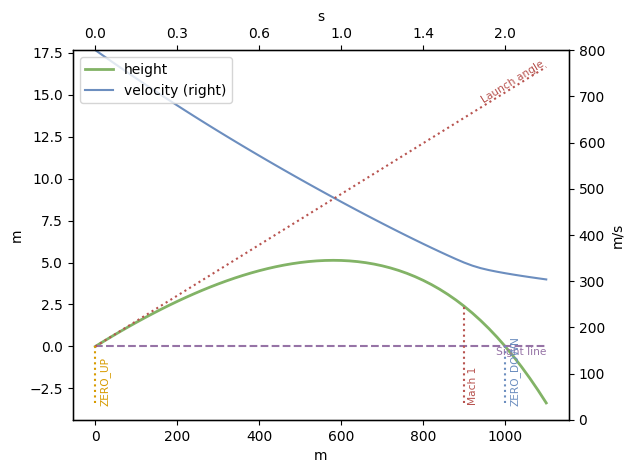

In [3]:
def create_7_62_mm_shot():  # 7.62x51mm NATO M118   
    dm = DragModel(bc=0.243, drag_table=TableG7, weight=Weight.Grain(175), diameter=Distance.Millimeter(7.62), length=Distance.Millimeter(32.0))
    return Shot(ammo=Ammo(dm, mv=Velocity.MPS(800)))
shot = create_7_62_mm_shot()
calc.set_weapon_zero(shot, zero_distance=Distance.Meter(1000))
t = calc.fire(shot, trajectory_range=Distance.Meter(1100), trajectory_step=Distance.Meter(20), extra_data=True)
t.plot()
plt.show()

## Table

Here is a table showing some of the details the calculator generates for points along the trajectory:

In [4]:
df = t.dataframe(True).drop(columns=['drop_adj', 'windage', 'windage_adj', 'density_factor', 'drag', 'ogw'])
df[df.distance.str.contains("00.") | (df.flag != "RANGE")]

,time,distance,velocity,mach,height,target_drop,look_distance,angle,energy,flag
0,0.000 s,0.0 m,800 m/s,2.35 mach,0.0 m,0.0 m,0.0 m,0.8672 °,3629 J,ZERO_UP|RANGE
5,0.130 s,100.0 m,739 m/s,2.17 mach,1.4 m,1.4 m,100.0 m,0.7721 °,3094 J,RANGE
10,0.271 s,200.0 m,680 m/s,2.00 mach,2.7 m,2.7 m,200.0 m,0.6602 °,2623 J,RANGE
15,0.425 s,300.0 m,624 m/s,1.84 mach,3.7 m,3.7 m,300.0 m,0.5278 °,2211 J,RANGE
20,0.592 s,400.0 m,571 m/s,1.68 mach,4.5 m,4.5 m,400.0 m,0.3702 °,1851 J,RANGE
25,0.775 s,500.0 m,520 m/s,1.53 mach,5.0 m,5.0 m,500.0 m,0.1811 °,1536 J,RANGE
30,0.937 s,580.6 m,481 m/s,1.41 mach,5.1 m,5.1 m,580.6 m,0.0000 °,1311 J,APEX
31,0.977 s,600.0 m,472 m/s,1.39 mach,5.1 m,5.1 m,600.0 m,-0.0479 °,1261 J,RANGE
36,1.201 s,700.0 m,425 m/s,1.25 mach,4.8 m,4.8 m,700.0 m,-0.3286 °,1024 J,RANGE
41,1.449 s,800.0 m,381 m/s,1.12 mach,3.9 m,3.9 m,800.0 m,-0.6764 °,822 J,RANGE


Some of these rows look duplicative.  "distance" and "look_distance" are always the same, as are "height" and "target_drop."  We'll get into the differences soon.  First, let's look at what the row corresponding to the APEX flag tells us:

In [5]:
df[df.flag == "APEX"]

,time,distance,velocity,mach,height,target_drop,look_distance,angle,energy,flag
30,0.937 s,580.6 m,481 m/s,1.41 mach,5.1 m,5.1 m,580.6 m,0.0000 °,1311 J,APEX


We define the apex of a trajectory as the point where vertical velocity goes from positive to negative.  This is equivalent to saying that the trajectory's angle is horizontal (i.e., 0°).  When present, the apex is the highest point in the trajectory.  In this example, it occurs at a distance of 580.6m along the sight line, and at that point the projectile is 5.1m above the sight line.

Another special point, which is also depicted on the chart, is the Mach crossing.  This occurs later in the trajectory while the projectile is 899.3m along the sight line and 2.4m above it:

In [6]:
df[df.flag == "MACH"]

,time,distance,velocity,mach,height,target_drop,look_distance,angle,energy,flag
46,1.726 s,899.3 m,340 m/s,1.00 mach,2.4 m,2.4 m,899.3 m,-1.1083 °,657 J,MACH


# Non-zero look-angle

So far we have been considering horizontal sight lines.  What happens if the shooter is looking at a target at a different altitude?  Let's imagine you have a friend on the roof of a tall building and you want to launch a ball for him to catch.  The building is 100m away on level ground, and he – the target – is 100m above the ground.  In a case like this it can be more intuitive to talk about the angle and straight-line distance to the target, which we can get from trigonometry:

In [7]:
horizontal_distance = 100.
altitude = 100.
look_angle = Angular.Radian(math.atan2(altitude, horizontal_distance))
look_distance = np.hypot(horizontal_distance, altitude)
print(f'Look-angle to target is {look_angle >> Angular.Degree} degrees. Look-distance is {look_distance:.1f}.')

Look-angle to target is 45.0 degrees. Look-distance is 141.4.


The sight-line to this target is 45 degrees above the horizontal, and the distance along the sight line (the look-distance, a.k.a. slant distance) is 141.4m.  Let's suppose we have a gun that launches a ball at 55mps and solve for the trajectory to get the ball to your friend:

Launch angle to hit the target is 63.2 degrees.


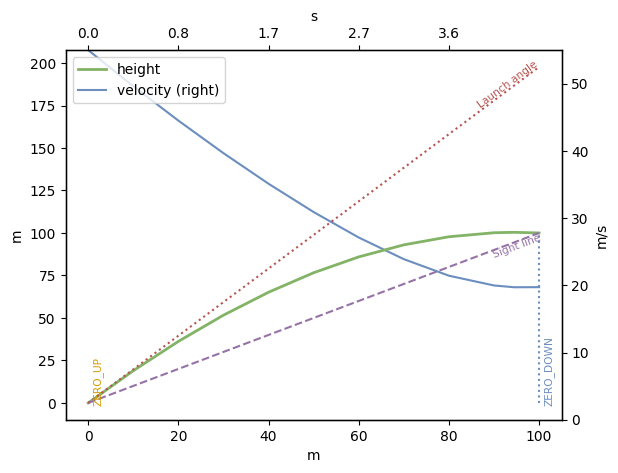

In [8]:
def create_ball_shot():
    dm = DragModel(bc=0.2, drag_table=TableGS)  # GS model is used for spherical projectiles
    return Shot(ammo=Ammo(dm, mv=Velocity.MPS(55)))
shot = create_ball_shot()
shot.look_angle = look_angle  # Set the look-angle to the one we calculated
calc.set_weapon_zero(shot, zero_distance=Distance.Meter(look_distance))
print(f'Launch angle to hit the target is {shot.barrel_elevation >> Angular.Degree:.1f} degrees.')
tball = calc.fire(shot, trajectory_range=Distance.Meter(100), trajectory_step=Distance.Meter(10), extra_data=True)
ax = tball.plot()
plt.show()

## Table

Now when we look at the detailed data we see that the "look_distance" is always greater than the "distance," and the "target_drop" is always less than the "height."

In [9]:
df = tball.dataframe(True).drop(columns=['drop_adj', 'windage', 'windage_adj', 'density_factor', 'energy', 'drag', 'ogw'])
df

,time,distance,velocity,mach,height,target_drop,look_distance,angle,flag
0,0.000 s,0.0 m,55 m/s,0.16 mach,0.0 m,0.0 m,0.0 m,63.1692 °,ZERO_UP|RANGE
1,0.410 s,10.0 m,50 m/s,0.15 mach,19.0 m,6.3 m,20.5 m,61.1088 °,RANGE
2,0.834 s,20.0 m,45 m/s,0.13 mach,36.2 m,11.5 m,39.7 m,58.5627 °,RANGE
3,1.271 s,30.0 m,40 m/s,0.12 mach,51.6 m,15.3 m,57.7 m,55.3768 °,RANGE
4,1.721 s,40.0 m,35 m/s,0.10 mach,65.1 m,17.8 m,74.3 m,51.3372 °,RANGE
5,2.183 s,50.0 m,31 m/s,0.09 mach,76.6 m,18.8 m,89.5 m,46.1493 °,RANGE
6,2.655 s,60.0 m,27 m/s,0.08 mach,85.9 m,18.3 m,103.2 m,39.4253 °,RANGE
7,3.137 s,70.0 m,24 m/s,0.07 mach,93.0 m,16.3 m,115.3 m,30.7149 °,RANGE
8,3.628 s,80.0 m,21 m/s,0.06 mach,97.8 m,12.6 m,125.7 m,19.6689 °,RANGE
9,4.128 s,90.0 m,20 m/s,0.06 mach,100.1 m,7.2 m,134.4 m,6.4247 °,RANGE


For every point in the trajectory:

* "distance" is always the $x$ coordinate, which is the horizontal distance from the sight towards the target.
* "height" is always the $y$ coordinate, which is the distance above or below the horizontal plane containing the sight.  Height is measured orthogonal to the horizontal axis.
* "look_distance" is the distance towards the target *along the sight line*, which meets the origin at look_angle (here, 45 degrees) relative to the horizontal.
* "target_drop" is the distance above or below the sight line, orthogonal to the sight line.  This is analogous to the height in the horizontal reference frame.

Given a look-angle $\theta$ it is straightforward to transform between the horizontal and sight-line frames:

* look_distance $= x \cos(\theta) + y \sin(\theta)$
* target_drop $= y \cos(\theta) - x \sin(\theta)$

## Diagram

To illustrate, we'll diagram these four lengths on the trajectory plot for the middle trajectory point (where "distance" is 50m):

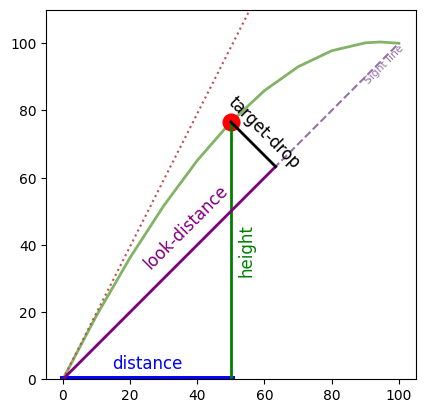

In [10]:
poi = tball.get_at_distance(Distance.Meter(50))
from py_ballisticcalc.visualize.plot import trajectory_as_plot
ax = trajectory_as_plot(tball)
ax.legend().set_visible(False)
ax.set_ylim([0, 110])
ax.set_xlabel('')
ax.set_ylabel('')
for txt in ax.texts:
    if "Launch" in txt.get_text():
        txt.remove()
ax.set_aspect('equal')
distance = poi.distance >> Distance.Meter
height = poi.height >> Distance.Meter
# Point of interest
ax.plot(distance, height, 'o', color='red', markersize=12, label='Target')
# Distance
ax.plot([0, distance], [0, 0], color='blue', linewidth=5)
ax.text(distance / 2, 2, 'distance', color='blue', fontsize=12, ha='center', va='bottom')
# Height
ax.plot([distance, distance], [0, height], color='green', linewidth=2)
ax.text(distance+2, height/2, 'height', color='green', fontsize=12, rotation=90, va='center', ha='left')
# Look_distance
angle = look_angle >> Angular.Degree
sine = math.sin(look_angle >> Angular.Radian)
look_distance = sine * (poi.look_distance >> Distance.Meter)
center = (look_distance) / 2
ax.plot([0, look_distance], [0, look_distance], color='purple', linewidth=2)
ax.text(center+5, center, 'look-distance', color='purple', fontsize=12, rotation=angle, ha='center', va='bottom')
# Target drop
target_drop = poi.target_drop >> Distance.Meter
ax.plot([look_distance, distance], [look_distance, height], color='black', linewidth=2)
ax.text(10 + look_distance - sine * target_drop, 10 + height - sine * target_drop, 'target-drop', color='black',
        fontsize=12, rotation=angle-90, va='center', ha='center')
#plt.savefig('look_angle.svg', bbox_inches='tight')
plt.show()